In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from dde import ddeint
import seaborn as sns
sns.set_context('paper', font_scale=1.3)
red, blue, green = sns.color_palette('Set1', 3)

# Deterministic discrete model

$$
I_{t+1} = I_t + b_t S_t I_t - \gamma I_t \quad (2.2) \\
b_t = b_0 c^*_t \quad (2.4) \\
c^*_t = \hat{c} - \alpha \frac{I_{(t-\Delta)}}{N} \quad (2.10)
$$

$$
f(I_t) = I_{t+1} = I_t^2 \big(\frac{b_0 \alpha}{N} I_{(t-\Delta)} - b_0 \hat{c} \big) + I_t (b_0 N \hat{c} -\alpha b_0 I_{(t-\Delta)} + 1 - \gamma)
\quad (2.11)
$$

$$
\frac{df}{dI} = 
1-\gamma+b_{0}\left(\hat{c} N-2 \alpha I-2 \hat{c} I+3 \alpha \frac{I^{2}}{N}\right)
$$

$$
\hat{I}_1 = \frac{\alpha +\hat{c} + \sqrt{\alpha^2 + \hat{c}^2 - 2\alpha \hat{c} + 4\frac{\alpha}{b_0 N} \gamma}}{2\frac{\alpha}{N}}
\quad (3.3) \\
\hat{I}_2 = \frac{\alpha +\hat{c} - \sqrt{\alpha^2 + \hat{c}^2 - 2\alpha \hat{c} + 4\frac{\alpha}{b_0 N} \gamma}}{2\frac{\alpha}{N}}
\quad (3.4)
$$

In [2]:
N = 10000
I0 = 1
b0 = 0.05
γ = 0.08
c_hat = 0.0015
α1 = 0.02
α2 = 0.3
Δ = 3

b0s = [0.005, 0.01, 0.03, 0.04, 0.05, 0.1]
Δs = [0, 1, 2, 3]

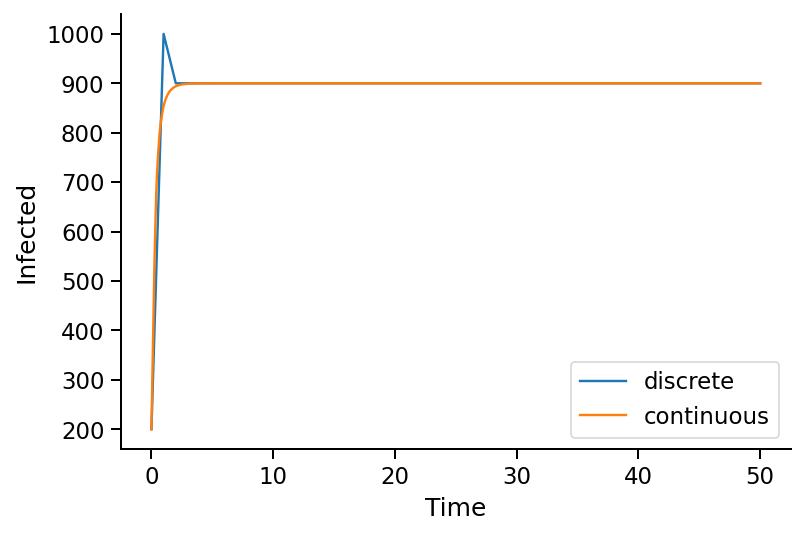

In [94]:
def f(It, IΔ, N, b0, γ, c_hat, α1, α2, min0=False, maxN=False):
    α = α2 / (2 * α1) * b0
    It1 = It * It * b0 * (α * IΔ / N - c_hat) + It * (b0 * N * c_hat - α * b0 * IΔ + 1 - γ)
    It1 = np.array(It1)
    if min0: It1[It1 < 0] = 0
    if maxN: It1[It1 > N] = N
    return It1

def dfdI(I, N, b0, γ, c_hat, α1, α2):
    α = α2 / (2 * α1) * b0
    return 1 - γ + b0 * (c_hat * N - 2 * α * I - 2 * c_hat * I + 3 * α * I * I / N)

def I2(N, b0, γ, c_hat, α1, α2):
    α = α2 / (2 * α1) * b0
    numer = α + c_hat - np.sqrt(α * α + c_hat * c_hat - 2 * α * c_hat + 4 * α * γ / (b0 * N))
    res = numer / (2 * α / N)
    if res < 0: return np.nan
    return res

def det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=500, min0=False, maxN=False):
    I = np.zeros(tmax+1)
    I[0] = I0
    for t in range(tmax):
        IΔ = I[t-Δ] if t-Δ >= 0 else 0
        I[t+1] = f(I[t], IΔ, N, b0, γ, c_hat, α1, α2, min0, maxN)
    return I

def dde(I, t, N, b0, γ, c_hat, α1, α2, Δ):
    return f(I(t), I(t-Δ), N, b0, γ, c_hat, α1, α2) - I(t)

def det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=500, npts=100):
    g = lambda t: I0
    t = np.linspace(0, tmax, tmax * npts)
    return t, ddeint(dde, g, t, fargs=(N, b0, γ, c_hat, α1, α2, Δ))    

I = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=50, maxN=True)
plt.plot(I, label='discrete')
t, I = det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=50)
plt.plot(t, I, label='continuous')
plt.xlabel('Time')
plt.ylabel('Infected')
plt.legend()
sns.despine()

In [4]:
print("Table 1")
print("b0\tI2")
for b0_ in b0s:
    print("{:.3f}\t{:.3f}".format(b0_, I2(N, b0_, γ, c_hat, α1, α2)))

Table 1
b0	I2
0.005	nan
0.010	92.339
0.030	54.750
0.040	43.304
0.050	35.718
0.100	18.931


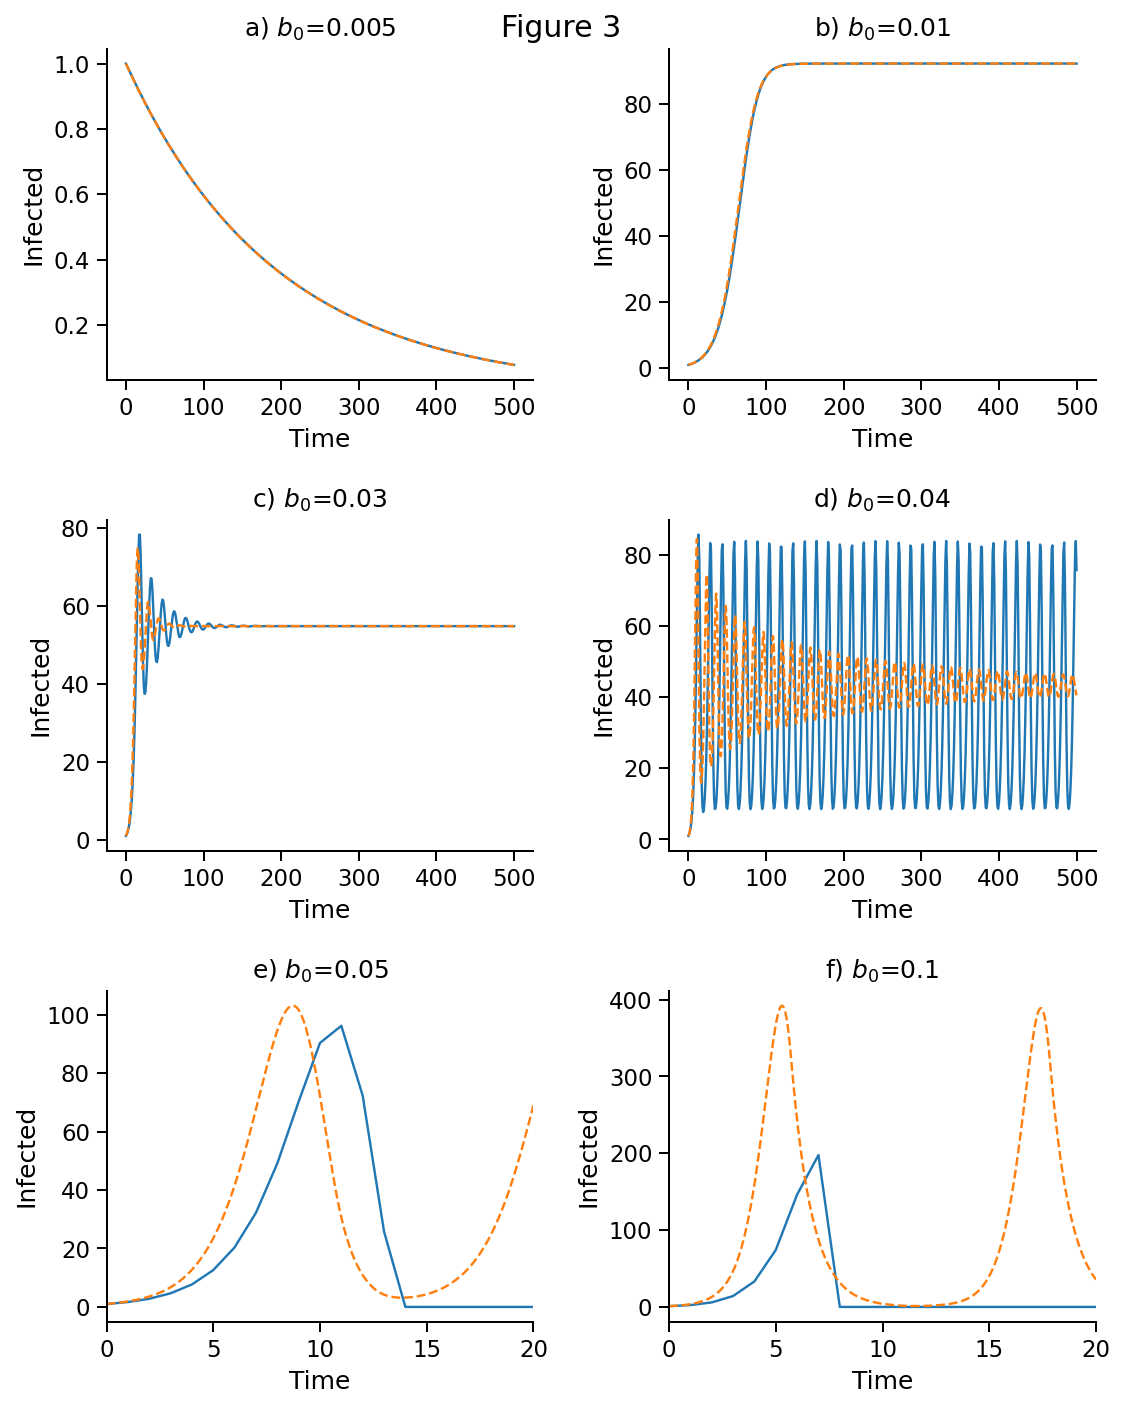

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
for b0_, ax, title in zip(b0s, axes.flat, 'abcdef'):
    I = det_dis_simulation(I0, N, b0_, γ, c_hat, α1, α2, Δ)
    ax.plot(I)
    t, I = det_cont_simulation(I0, N, b0_, γ, c_hat, α1, α2, Δ)
    ax.plot(t, I, '--')
    ax.set_ylabel('Infected')
    ax.set_xlabel('Time')
    ax.set_title("{}) $b_0$={}".format(title, b0_))
axes[2,0].set_xlim(0, 20)
axes[2,1].set_xlim(0, 20)
plt.suptitle('Figure 3')
fig.tight_layout()
sns.despine()
plt.savefig('../figures/fig3.pdf')

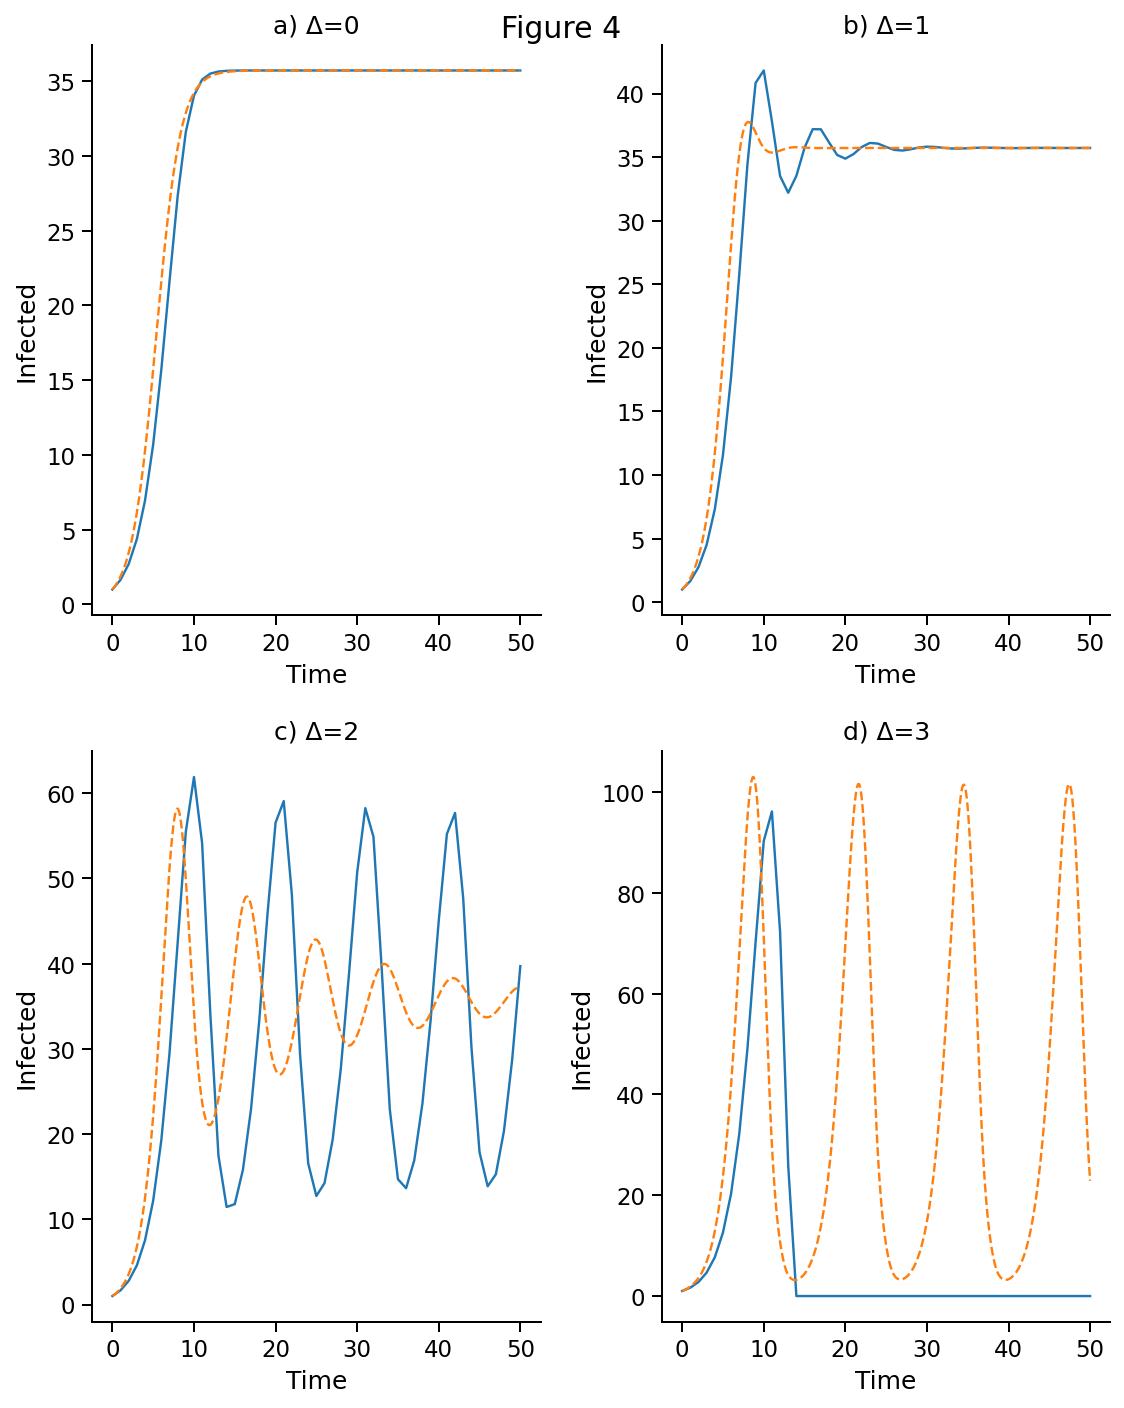

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10))
for Δ_, ax, title in zip(Δs, axes.flat, 'abcdef'):
    I = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=50)
    ax.plot(I)
    t, I = det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=50)
    ax.plot(t, I, '--')
    ax.set_ylabel('Infected')
    ax.set_xlabel('Time')
    ax.set_title("{}) Δ={}".format(title, Δ_))
# axes[1,1].set_xlim(0, 20)
plt.suptitle('Figure 4')
fig.tight_layout()
sns.despine()
plt.savefig('../figures/fig4.pdf')

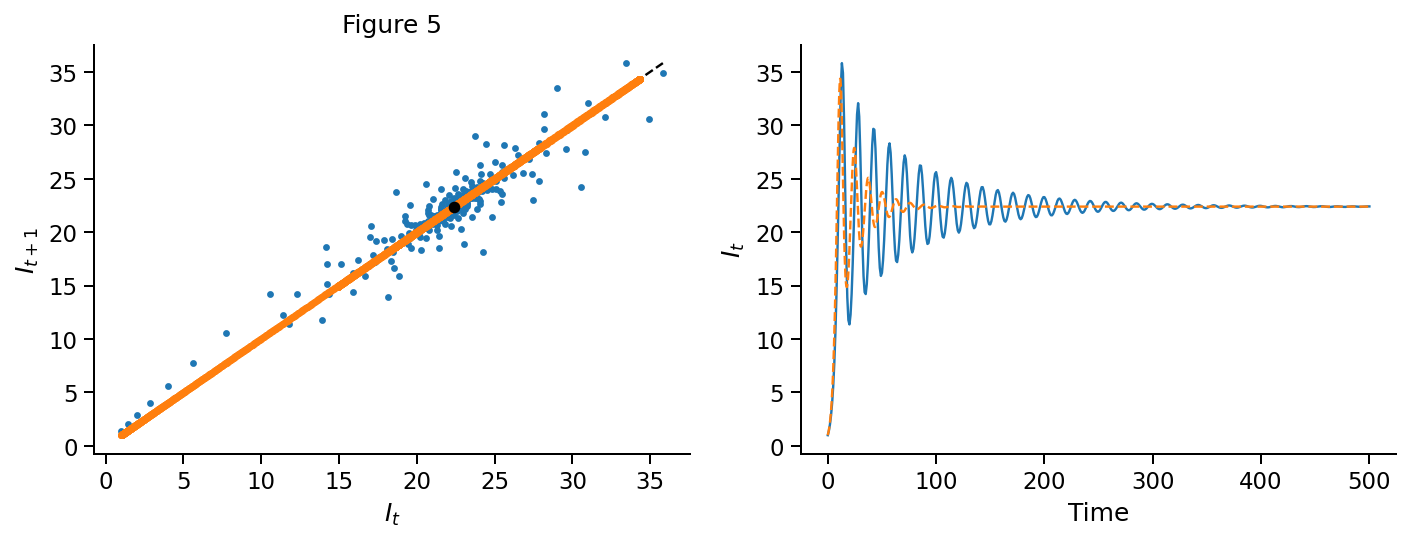

In [7]:
c_hat_ = 0.001

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
I = det_dis_simulation(I0, N, b0, γ, c_hat_, α1, α2, Δ)
ax.plot(I[:-1], I[1:], '.')
axes[1].plot(I)
line = np.linspace(I.min(), I.max())
ax.plot(line, line, ls='--', color='k')
t, I = det_cont_simulation(I0, N, b0, γ, c_hat_, α1, α2, Δ)
ax.plot(I[:-1], I[1:], '.')
axes[1].plot(t, I, '--')
ax.plot(I2(N, b0, γ, c_hat_, α1, α2), I2(N, b0, γ, c_hat_, α1, α2), 'ok')
ax.set_xlabel('$I_t$')
ax.set_ylabel('$I_{t+1}$')
ax.set_title('Figure 5')

axes[1].set(xlabel='Time', ylabel='$I_t$')

sns.despine()
fig.tight_layout()
fig.savefig('../figures/fig5.pdf')

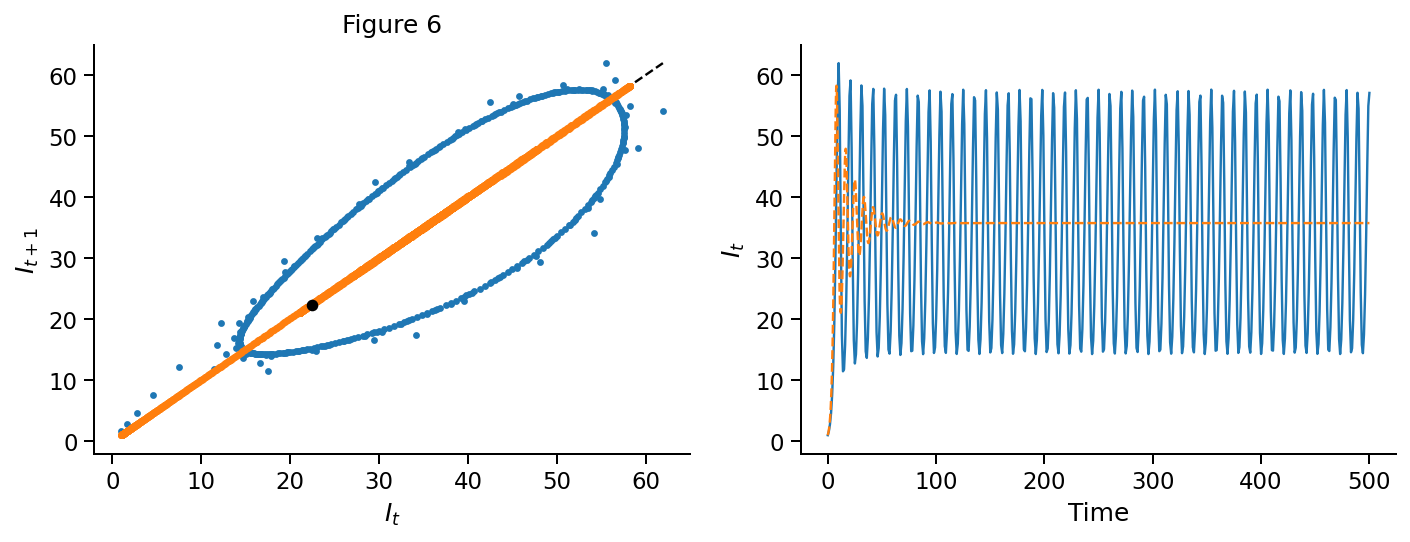

In [8]:
Δ_ = 2

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
I = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_)
ax.plot(I[:-1], I[1:], '.')
axes[1].plot(I)
line = np.linspace(I.min(), I.max())
ax.plot(line, line, ls='--', color='k')
t, I = det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_)
ax.plot(I[:-1], I[1:], '.')
axes[1].plot(t, I, '--')
ax.plot(I2(N, b0, γ, c_hat_, α1, α2), I2(N, b0, γ, c_hat_, α1, α2), 'ok')
ax.set_xlabel('$I_t$')
ax.set_ylabel('$I_{t+1}$')
ax.set_title('Figure 6')

axes[1].set(xlabel='Time', ylabel='$I_t$')

sns.despine()
fig.tight_layout()
fig.savefig('../figures/fig6.pdf')

# Stochastic discrete model

$$
I_{t+1} = I_t + Poi(b_t S_t I_t) - Poi(\gamma I_t) \\
b_t = b_0 c^*_t \quad (2.4) \\
c^*_t = \hat{c} - \alpha \frac{I_{(t-\Delta)}}{N} \quad (2.10)
$$

In [9]:
poi = np.random.poisson

def stoch_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=500):
    α = α2 / (2 * α1) * b0
    I = np.zeros(tmax+1, dtype=int)
    I[0] = I0
    for t in range(tmax):
        IΔ = I[t-Δ] if t-Δ >= 0 else 0
        bt = max(0, b0 * c_hat - α * IΔ / N)
#         assert bt * I[t] * (N - I[t]) >= 0, (t, bt * I[t] * (N - I[t]), bt, I[t], IΔ)
#         assert γ * I[t] >= 0, γ * I[t]
        I[t+1] = I[t] + poi(bt * I[t] * (N - I[t])) - poi(γ * I[t])
        if I[t+1] < 0: I[t+1] = 0
    return I

In [10]:
def multi_stoch_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=500, reps=100):
    return np.array([stoch_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax) for _ in range(reps)])

In [11]:
def multiplot():
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].plot(EI[:-1], EI[1:], '.', color=blue)
    axes[0].plot(Ibar[:-1], Ibar[1:], '.', color=red)
    for i in range(10):
        axes[0].plot(I[i,:-1], I[i,1:], '-.', alpha=0.5, color='k')
    axes[0].set(xlabel='$I_t$', ylabel='$I_{t+1}$')
    line = np.linspace(EI.min(), EI.max())
    axes[0].plot(line, line, ls='--', color='k', alpha=0.6)

    axes[1].plot(I.T, color='k', alpha=0.5)
    axes[1].plot(EI, color=blue)
    axes[1].plot(Ibar, color=red)
    axes[1].set(xlabel='Time', ylabel='Infected')

    fig.tight_layout()
    sns.despine()

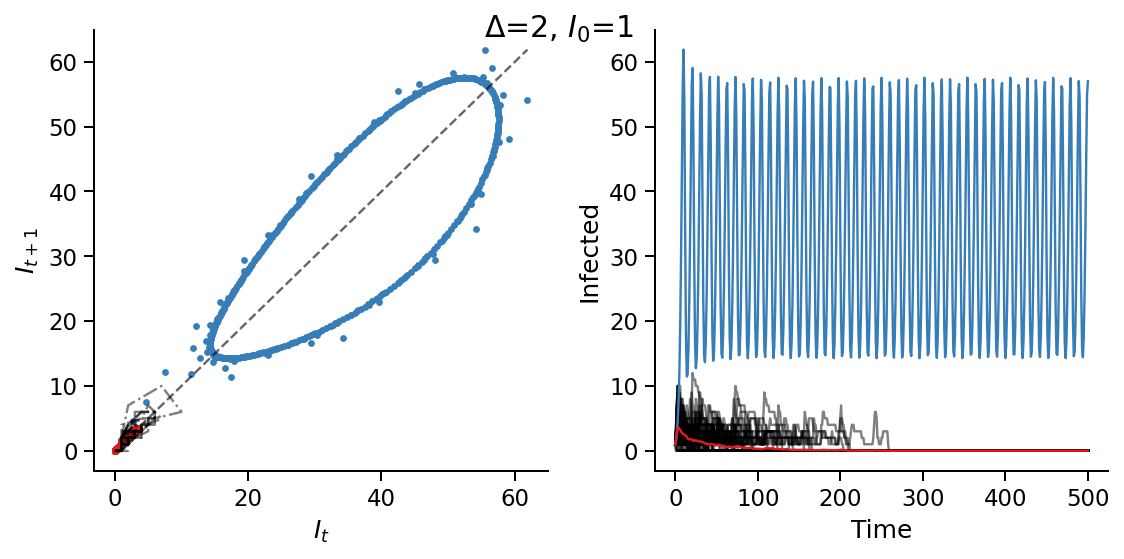

In [12]:
Δ_ = 2

EI = det_dis_simulation(1, N, b0, γ, c_hat, α1, α2, Δ_)
I = multi_stoch_dis_simulation(1, N, b0, γ, c_hat, α1, α2, Δ_)
Ibar = I.mean(axis=0)

multiplot()
plt.suptitle("$\Delta$=2, $I_0$=1");

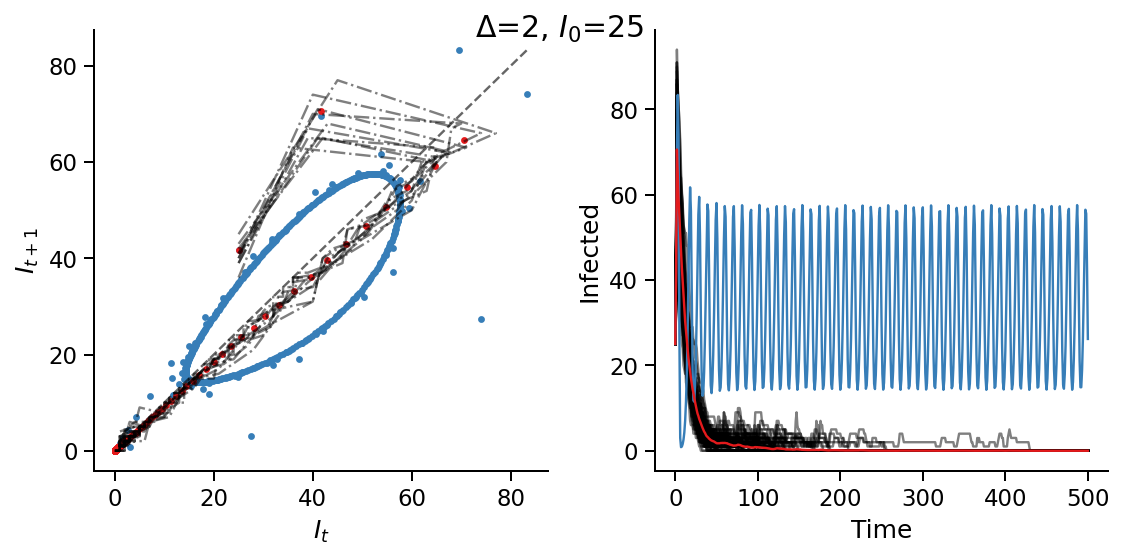

In [13]:
Δ_ = 2

EI = det_dis_simulation(25, N, b0, γ, c_hat, α1, α2, Δ_)
I = multi_stoch_dis_simulation(25, N, b0, γ, c_hat, α1, α2, Δ_)
Ibar = I.mean(axis=0)

multiplot()
plt.suptitle("$\Delta$=2, $I_0$=25");

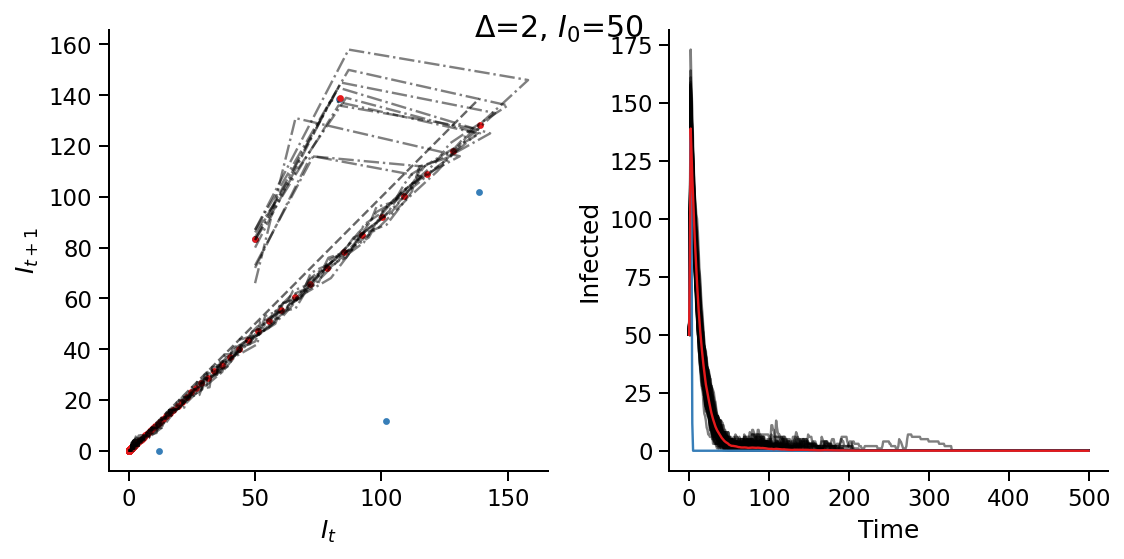

In [14]:
Δ_ = 2

EI = det_dis_simulation(50, N, b0, γ, c_hat, α1, α2, Δ_)
I = multi_stoch_dis_simulation(50, N, b0, γ, c_hat, α1, α2, Δ_)
Ibar = I.mean(axis=0)

multiplot()
plt.suptitle("$\Delta$=2, $I_0$=50");

# Case 19

The odd thing here is that the intermediate equilibrium I2 is stable (|df/dI|<1) but the derivative is not positive across the range, so you cannot prove global convergence, but nevertheless it seems like the dynamics converge to I2. Moreover it seems like the It->It+1 map goes up, then down, then up back again.

In [95]:
N, b0, α, γ, c_hat, Δ = 250, 0.115, 0.1, 0.1, 0.1, 0
# α = α2 / (2 * α1) * b0 => α2 = α * 2 * α1 / b0
α1, α2 = 1, α * 2 / b0

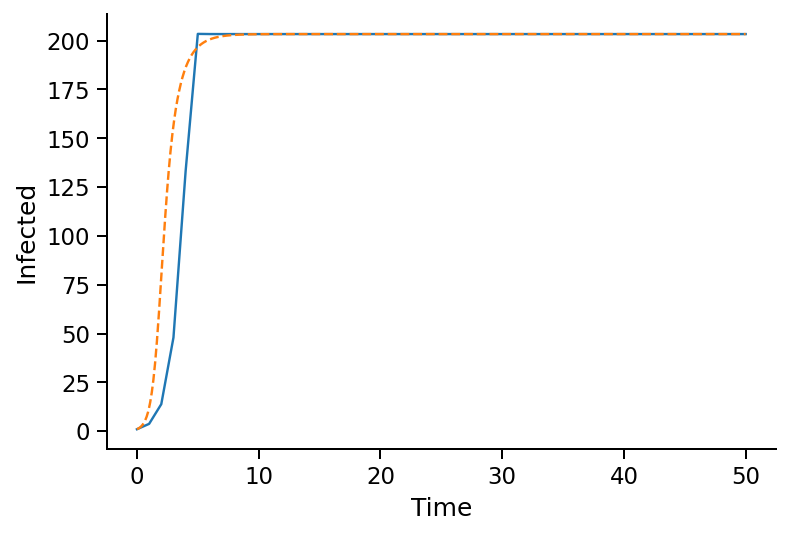

In [96]:
I = det_dis_simulation(1, N, b0, γ, c_hat, α1, α2, Δ, tmax=50)
plt.plot(I)
t, I = det_cont_simulation(1, N, b0, γ, c_hat, α1, α2, Δ, tmax=50)
plt.plot(t, I, '--')
plt.xlabel('Time')
plt.ylabel('Infected')
sns.despine()

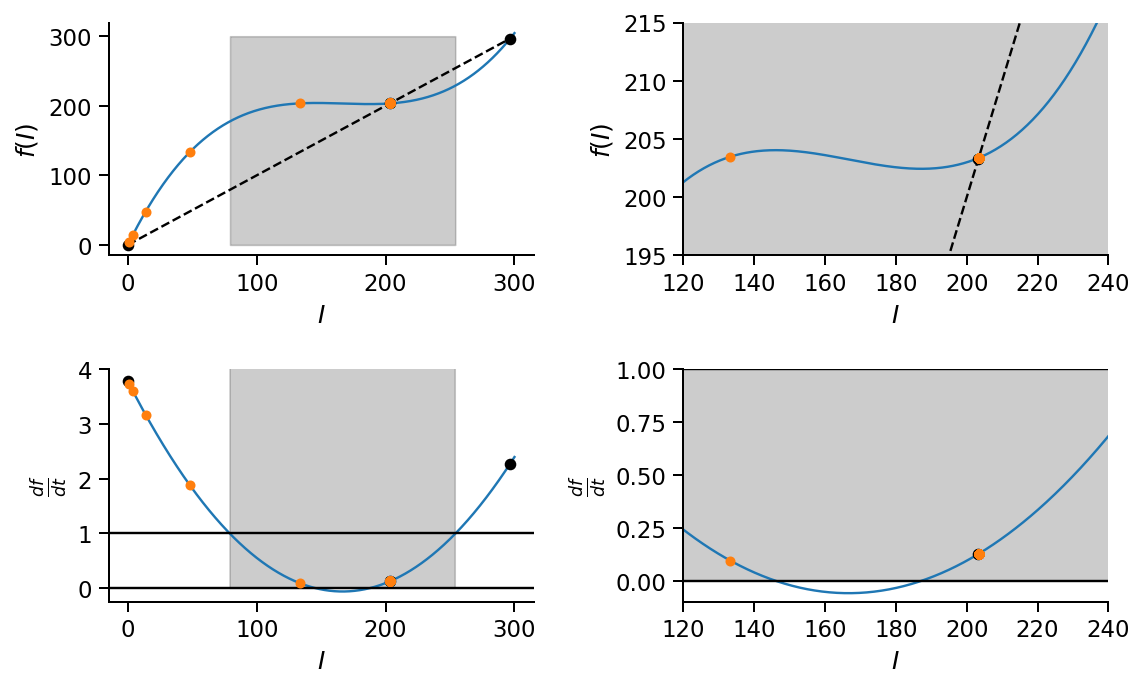

In [97]:
I = det_dis_simulation(1, N, b0, γ, c_hat, α1, α2, Δ, tmax=50)
Is = np.linspace(0, 1.2*N, 1000)
fIs = f(Is, Is, N, b0, γ, c_hat, α1, α2)
I2_ = I2(N, b0, γ, c_hat, α1, α2)
fI2 = f(I2_, I2_, N, b0, γ, c_hat, α1, α2)
dfIs = dfdI(Is, N, b0, γ, c_hat, α1, α2)
dfI2 = dfdI(I2_, N, b0, γ, c_hat, α1, α2)
idx_star = (abs(fIs - Is) < 1e-1)
idx_stable = abs(dfIs)<1

fig, axes = plt.subplots(2, 2, figsize=(8, 5))

for ax in axes[0]:
    ax.plot(Is, fIs)
    ax.set_xlabel(r'$I$')
    ax.set_ylabel(r'$f(I)$')
    ax.plot(Is, Is, ls='--', color='k')
    for I_ in Is[idx_star]:
        ax.plot(I_, I_, 'ok')
    ax.fill_between(Is[idx_stable], 0, Is.max(), alpha=0.2, color='k')
    ax.plot(I, f(I, I, N, b0, γ, c_hat, α1, α2), 'o', markersize=4)
axes[0,1].set(xlim=(120, 240), ylim=(195, 215))

for ax in axes[1]:
    ax.plot(Is, dfIs)
    ax.axhline(1, color='k')
    ax.axhline(0, color='k')
    ax.set_ylim(None, 4)
    # ax.plot(I2, dfI2, 'ok')
    for I_ in Is[idx_star]:
        ax.plot(I_, dfdI(I_, N, b0, γ, c_hat, α1, α2), 'ok')
    ax.set_xlabel(r'$I$')
    ax.set_ylabel(r'$\frac{df}{dt}$')
    ax.fill_between(Is[idx_stable], 0, Is.max(), alpha=0.2, color='k')
    ax.plot(I, dfdI(I, N, b0, γ, c_hat, α1, α2), 'o', markersize=4)
axes[1,1].set(xlim=(120, 240), ylim=(-0.1, 1))

fig.tight_layout()
sns.despine()

$$
f(I_t) = I_{t+1} \\
f(I^*) = I^* \\
\mid \frac{ f(I^* + \epsilon) - I^* }{ \epsilon } \mid < 1 \Rightarrow I^* \text{locally stable} \\ 
\lim_{\epsilon \to 0}{\frac{ f(I^* + \epsilon) - I^* }{ \epsilon }} = \frac{df}{dI}
$$

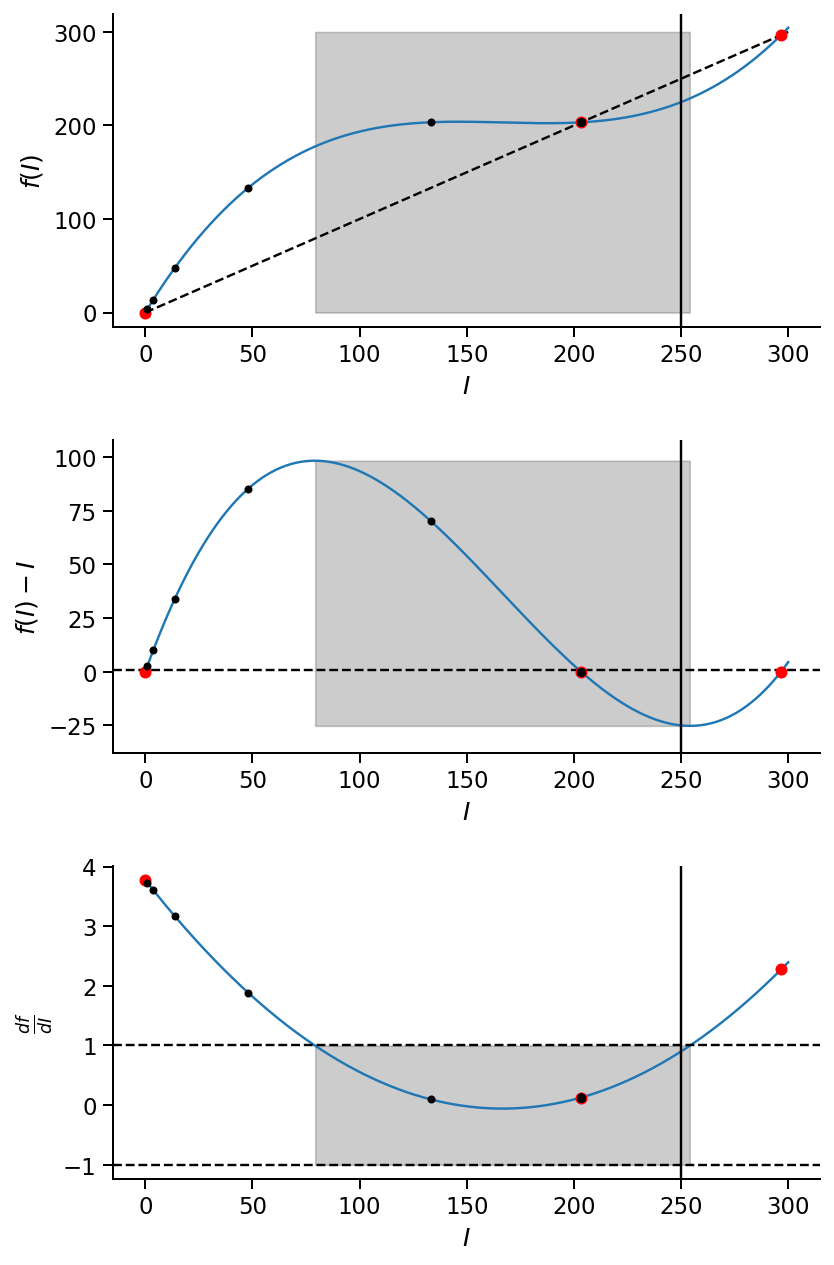

In [98]:
fig, axes = plt.subplots(3, 1, figsize=(6, 9))

ax = axes[0]
ax.plot(Is, fIs)
ax.set_xlabel(r'$I$')
ax.set_ylabel(r'$f(I)$')
ax.plot(Is, Is, ls='--', color='k')
for I_ in Is[idx_star]:
    ax.plot(I_, I_, 'or', markersize=5)
ax.fill_between(Is[idx_stable], 0, Is.max(), alpha=0.2, color='k')
ax.plot(I, f(I, I, N, b0, γ, c_hat, α1, α2), 'ok', markersize=3)
ax.axvline(N, color='k')

ax = axes[1]
ax.plot(Is, fIs-Is)
ax.set_xlabel(r'$I$')
ax.set_ylabel(r'$f(I)-I$')
ax.axhline(1, color='k', ls='--')
for I_ in Is[idx_star]:
    ax.plot(I_, 0, 'or', markersize=5)
ax.fill_between(Is[idx_stable], (fIs-Is).min(), (fIs-Is).max(), alpha=0.2, color='k')
ax.set_ylim((fIs-Is).min()*1.5, (fIs-Is).max()*1.1)
ax.plot(I, f(I, I, N, b0, γ, c_hat, α1, α2) - I, 'ok', markersize=3)
ax.axvline(N, color='k')

ax = axes[2]
ax.plot(Is, dfIs)
for I_ in Is[idx_star]:
    ax.plot(I_, dfdI(I_, N, b0, γ, c_hat, α1, α2), 'or', markersize=5)
ax.set_xlabel(r'$I$')
ax.set_ylabel(r'$\frac{df}{dI}$')
ax.axhline(1, color='k', ls='--')
ax.axhline(-1, color='k', ls='--')
# ax.set_ylim(-2, None)
ax.fill_between(Is[idx_stable], -1, 1, alpha=0.2, color='k')
ax.plot(I, dfdI(I, N, b0, γ, c_hat, α1, α2), 'ok', markersize=3)
ax.axvline(N, color='k')
fig.tight_layout()
sns.despine()

# Case 23

In [99]:
N, b0, α, γ, c_hat, Δ = 250, 0.273, 0.1, 0.1, 0.1, 0
α1, α2 = 1, α * 2 / b0

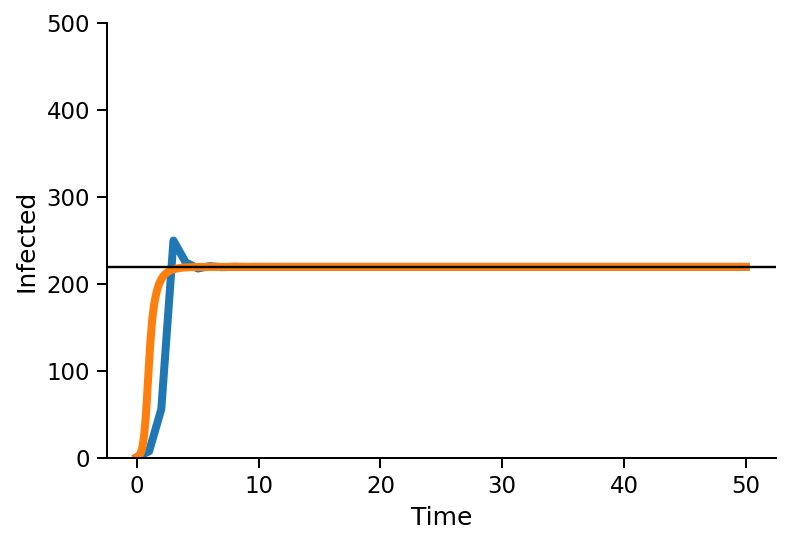

In [101]:
I = det_dis_simulation(1, N, b0, γ, c_hat, α1, α2, Δ, tmax=50, min0=True, maxN=True)
plt.plot(I, lw=4)
t, I = det_cont_simulation(1, N, b0, γ, c_hat, α1, α2, Δ, tmax=50)
plt.plot(t, I, '-', lw=4)
plt.xlabel('Time')
plt.ylabel('Infected')
plt.ylim(0, 2*N)
plt.axhline(I2(N, b0, γ, c_hat, α1, α2), color='k')
sns.despine()

# Case 36

In [102]:
N, b0, α, γ, c_hat, Δ = 250,0.1,35,0.1, 0.1, 0
α1, α2 = 1, α * 2 / b0

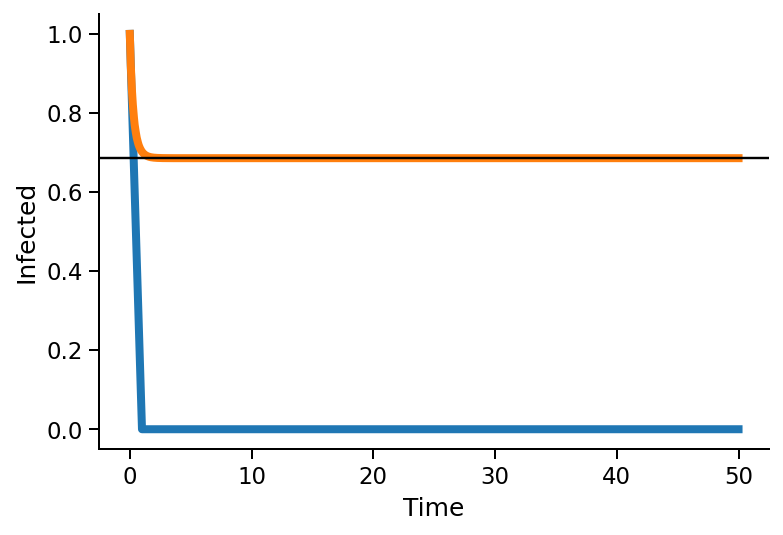

In [103]:
I = det_dis_simulation(1, N, b0, γ, c_hat, α1, α2, Δ, tmax=50, min0=True, maxN=True)
plt.plot(I, lw=4)
t, I = det_cont_simulation(1, N, b0, γ, c_hat, α1, α2, Δ, tmax=50)
plt.plot(t, I, '-', lw=4)
plt.xlabel('Time')
plt.ylabel('Infected')
# plt.ylim(0, N)
plt.axhline(I2(N, b0, γ, c_hat, α1, α2), color='k')
sns.despine()

In [45]:
print('I2 =', I2(N, b0, γ, c_hat, α1, α2))

I2 = 0.685635711855045


# Case 49

In [105]:
N, b0, α, γ, c_hat, Δ = 250, 0.1,0.1,0.1,0.209, 0
α1, α2 = 1, α * 2 / b0

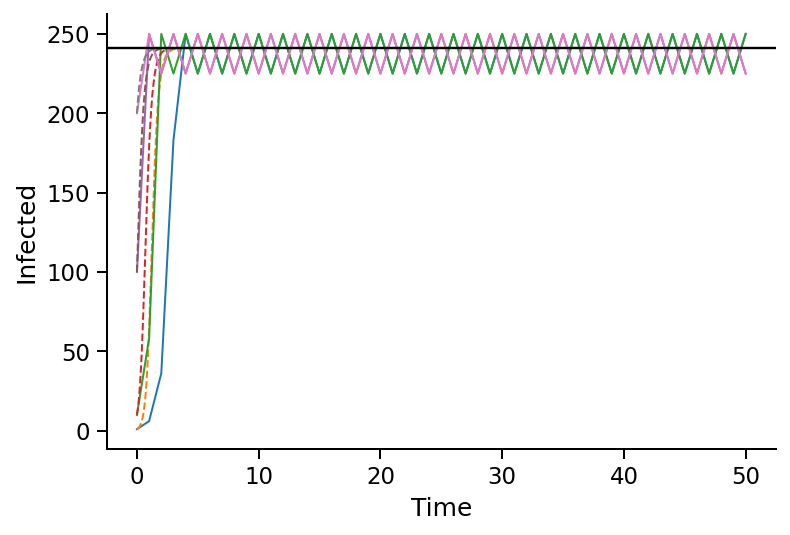

In [106]:
for I0 in [1, 10, 100, 200]:
    I = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=50, min0=True, maxN=True)
    plt.plot(I, lw=1)
    t, I = det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=50)
    plt.plot(t, I, '--', lw=1)
plt.xlabel('Time')
plt.ylabel('Infected')
plt.axhline(I2(N, b0, γ, c_hat, α1, α2), color='k')
sns.despine()

# Case 42

In [107]:
N, b0, α, γ, c_hat, Δ = 250,0.1,0.1,0.2,0.1, 0
α1, α2 = 1, α * 2 / b0

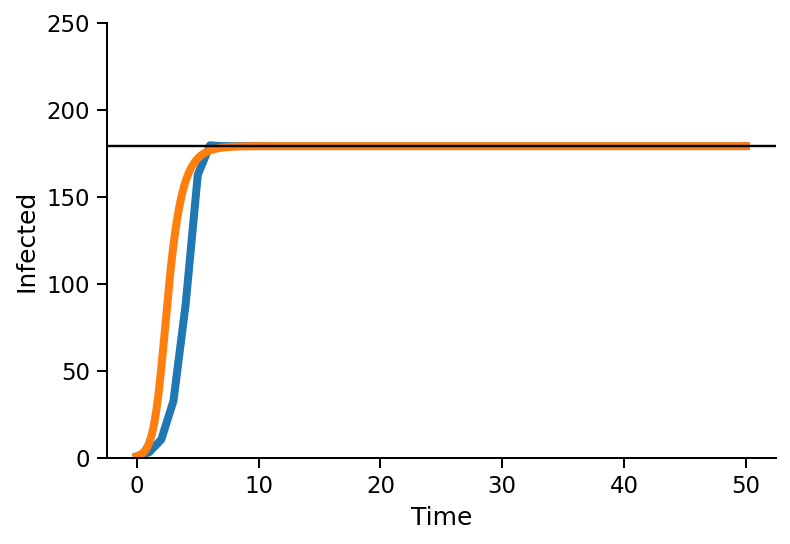

In [108]:
I = det_dis_simulation(1, N, b0, γ, c_hat, α1, α2, Δ, tmax=50, min0=True, maxN=True)
plt.plot(I, lw=4)
t, I = det_cont_simulation(1, N, b0, γ, c_hat, α1, α2, Δ, tmax=50)
plt.plot(t, I, '-', lw=4)
plt.xlabel('Time')
plt.ylabel('Infected')
plt.ylim(0, N)
plt.axhline(I2(N, b0, γ, c_hat, α1, α2), color='k')
sns.despine()

# Case 8

In [109]:
N, b0, α, γ, c_hat, Δ = 1000,0.1,0.1,0.1,0.1,0
α1, α2 = 1, α * 2 / b0

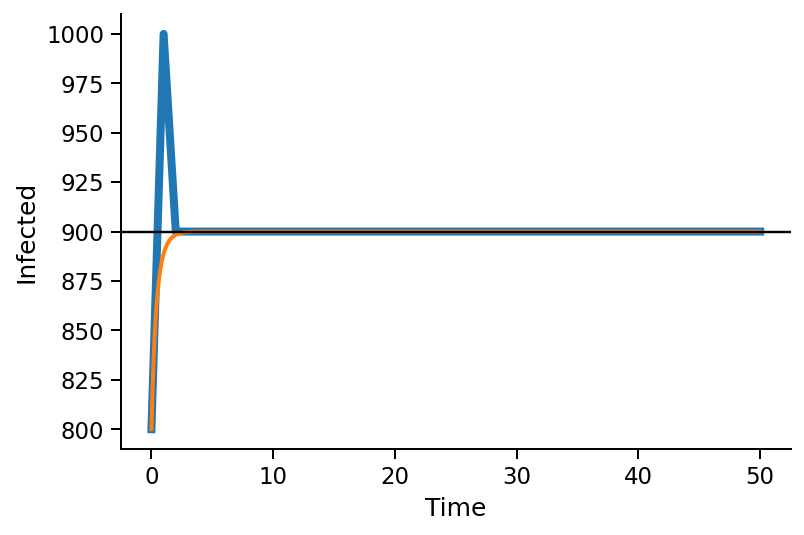

In [110]:
I = det_dis_simulation(800, N, b0, γ, c_hat, α1, α2, Δ, tmax=50, min0=True, maxN=True)
plt.plot(I, lw=4)
t, I = det_cont_simulation(800, N, b0, γ, c_hat, α1, α2, Δ, tmax=50)
plt.plot(t, I, '-', lw=2)
plt.xlabel('Time')
plt.ylabel('Infected')
# plt.ylim(0, N)
plt.axhline(I2(N, b0, γ, c_hat, α1, α2), color='k')
sns.despine()